In [1]:
# You may need to install htmllib5,lxml, and BeautifulSoup4. In your terminal/command prompt run:

# conda install lxml
# conda install html5lib
# conda install BeautifulSoup4
# Then restart Jupyter Notebook. (or use pip install if you aren't using the Anaconda Distribution)

import numpy as np
import pandas as pd
import os.path
from datetime import datetime, timedelta

one_hour_ago = datetime.now() - timedelta(hours=1)
if os.path.exists("history.csv"):
    filetime = datetime.fromtimestamp(os.path.getctime("history.csv"))
    if filetime < one_hour_ago:
        histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
        histdata[0].to_csv('history.csv',index=False)
else:
    histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
    histdata[0].to_csv('history.csv',index=False)

df = pd.read_csv('history.csv').set_index('Ticker')
df.index.name=None

df[["Date","Catalyst"]] = df.Catalyst.str.extract('(?P<Date>[0-9]{2}\/[0-9]{2}\/[0-9]{4})(?P<Catalyst>.*)', expand=True)

df.loc["OCUL"]


,Drug,Stage,Catalyst,Date
OCUL,DEXTENZA Allergic conjunctivitis,Phase 3,Phase 3 trial did not meet primary endpoint ...,06/06/2016
OCUL,DEXTENZA Ocular inflammation and pain followi...,Approved,CRL July 25 2016 - due to manufacturing defi...,07/25/2016
OCUL,DEXTENZA Ocular inflammation and pain followi...,Approved,CRL July 25 2016 - due to manufacturing defi...,07/11/2017
OCUL,DEXTENZA Ocular inflammation and pain followi...,Approved,"FDA approval announced December 3, 2018.",12/03/2018


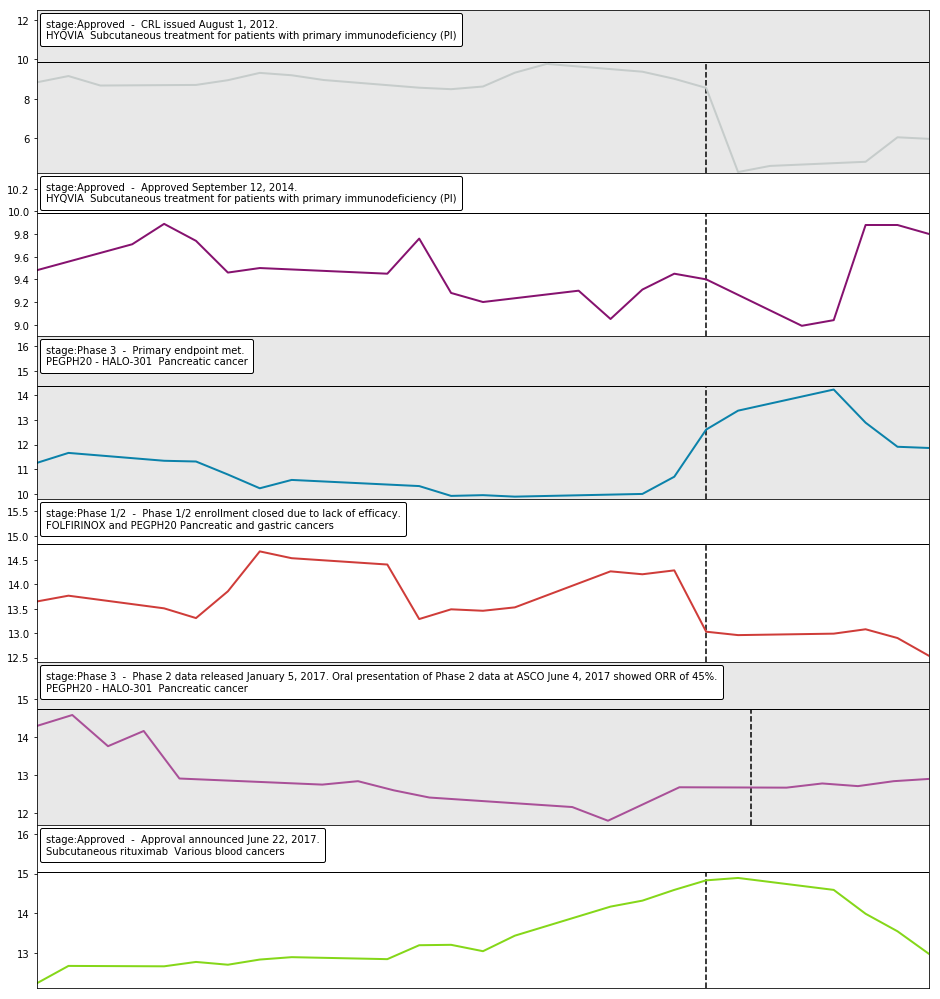

In [469]:
# You may need to install htmllib5,lxml, and BeautifulSoup4. In your terminal/command prompt run:

# conda install lxml
# conda install html5lib
# conda install BeautifulSoup4
# Then restart Jupyter Notebook. (or use pip install if you aren't using the Anaconda Distribution)
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import *
from pylab import text
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import quandl


# Quandl API key
quandl.ApiConfig.api_key = "UsYsv7dKGxHHQ5oURP4B"

# Some formatting
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_seq_items', 2)

# Only pull fresh PDUFA data
three_weeks_ago = relativedelta(weeks=3)
one_week_ahead = relativedelta(weeks=1)
one_hour_ago = datetime.now() - timedelta(hours=1)
if os.path.exists("history.csv"):
    filetime = datetime.fromtimestamp(os.path.getctime("history.csv"))
    if filetime < one_hour_ago:
        histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
        histdata[0].to_csv('history.csv',index=False)
else:
    histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
    histdata[0].to_csv('history.csv',index=False)

# Create dataframe
df = pd.read_csv('history.csv').set_index('Ticker')
df.index.name=None
df[["Date","Catalyst"]] = df.Catalyst.str.extract('(?P<Date>[0-9]{2}\/[0-9]{2}\/[0-9]{4})(?P<Catalyst>.*)', expand=True)
df['Date'] = pd.to_datetime(df['Date'])
df["Past"] = df["Date"] - DateOffset(weeks=3)
df["Future"] = df["Date"] + DateOffset(weeks=1)

df
# Set stock ticker
stockpick="HALO"
dataset=str(f"WIKI/{stockpick}")
# Set variables for plot creation
length = len(df.loc[stockpick].index)
count = 0
fig, axes = plt.subplots(nrows=length, ncols=1,figsize=(16,length * 3))
fig.subplots_adjust(hspace=0, wspace=0)
allplots=[]

# Combine all data together into list of dataframes, iterate through each part of the list, plot each frame.
while (count < length):
    pasttime= df.loc[stockpick].iloc[count]["Past"]
    futuretime= df.loc[stockpick].iloc[count]["Future"]
    pdufa=df.loc[stockpick].iloc[count]["Date"]
    annotate = df.loc[stockpick].iloc[count]["Date"] + timedelta(days=1)
    stage = df.loc[stockpick].iloc[count]["Stage"]
    catalyst = df.loc[stockpick].iloc[count]["Catalyst"]
    drug = df.loc[stockpick].iloc[count]["Drug"]
    
    #Annotation
    tooltip = f"stage:{stage}  -{catalyst}\n{drug}"
    at = AnchoredText(tooltip,
                      prop=dict(size=10), frameon=True,
                      loc=2, 
                      )
    at.patch.set_boxstyle("round,pad=0.2,rounding_size=0.2")
    axes[count].add_artist(at)
    axes[count].margins(0.0, 0.5)
    #Get quandl data
    mydata = quandl.get(dataset,start_date=pasttime,end_date=futuretime)
    allplots.append(mydata)
#     axes[count].annotate('local max', xy=(pdufa, allplots[count]["Close"].max()), xytext=(annotate, (allplots[count]["Close"].max() - allplots[count]["Close"].min()) * 0.9 + allplots[count]["Close"].min()),
#             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),)
    # Set y limit for notes
    axes[count].set_ylim(allplots[count]["Close"].min() * .99 , (allplots[count]["Close"].max()-allplots[count]["Close"].min()) * 0.5 + allplots[count]["Close"].max())
    axes[count].hlines(allplots[count]["Close"].max() * 1.01, allplots[count].head(1).index, allplots[count].tail(1).index, linestyle="-", lw=1, color='black')
    if count % 2 == 0:
        axes[count].set_facecolor((0.91, 0.91, 0.91))  

    axes[count].vlines(pdufa, allplots[count]["Close"].min() * .99, allplots[count]["Close"].max() * 1.01, linestyle="--", color='black')
    axes[count].plot(allplots[count].index,allplots[count]["Close"],c=np.random.rand(3,), lw=2, label=pdufa) 
    axes[count].axes.get_xaxis().set_visible(False) # remove x axis
    count = count + 1
plt.show()

In [54]:
# You may need to install htmllib5,lxml, and BeautifulSoup4. In your terminal/command prompt run:

# conda install lxml
# conda install html5lib
# conda install BeautifulSoup4
# Then restart Jupyter Notebook. (or use pip install if you aren't using the Anaconda Distribution)
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import *
from pylab import text
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import quandl


# Quandl API key
quandl.ApiConfig.api_key = "UsYsv7dKGxHHQ5oURP4B"

# Some formatting
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_seq_items', 2)

# Only pull fresh PDUFA data
three_weeks_ago = relativedelta(weeks=3)
one_week_ahead = relativedelta(weeks=1)
one_hour_ago = datetime.now() - timedelta(hours=1)
if os.path.exists("history.csv"):
    filetime = datetime.fromtimestamp(os.path.getctime("history.csv"))
    if filetime < one_hour_ago:
        histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
        histdata[0].to_csv('history.csv',index=False)
else:
    histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
    histdata[0].to_csv('history.csv',index=False)

# Create dataframe
df = pd.read_csv('history.csv').set_index('Ticker')
df.index.name=None
df[["Date","Catalyst"]] = df.Catalyst.str.extract('(?P<Date>[0-9]{2}\/[0-9]{2}\/[0-9]{4})(?P<Catalyst>.*)', expand=True)
df['Date'] = pd.to_datetime(df['Date'])
df["Past"] = df["Date"] - DateOffset(weeks=3)
df["Future"] = df["Date"] + DateOffset(weeks=1)

df
# Set stock ticker
stockpick="HALO"
dataset=str(f"WIKI/{stockpick}")
# Set variables for plot creation
length = len(df.loc[stockpick].index)
count = 0
allplots=[]

# Combine all data together into list of dataframes, iterate through each part of the list, plot each frame.
while (count < length):
    pasttime= df.loc[stockpick].iloc[count]["Past"]
    futuretime= df.loc[stockpick].iloc[count]["Future"]
    pdufa=df.loc[stockpick].iloc[count]["Date"]
    annotate = df.loc[stockpick].iloc[count]["Date"] + timedelta(days=1)
    stage = df.loc[stockpick].iloc[count]["Stage"]
    catalyst = df.loc[stockpick].iloc[count]["Catalyst"]
    drug = df.loc[stockpick].iloc[count]["Drug"]
    
    #Annotation
    #Get quandl data
    mydata = quandl.get(dataset,start_date=pasttime,end_date=futuretime)
    allplots.append(mydata)
    count = count + 1
# len(allplots[3].index) # 21
i=0
total = len(allplots[3].index) - 1

while (i < total):
    print(allplots[3].iloc[i]["Close"])
    n = i + 1
    while (n < total):  # see 14 - 8 = 1.0 !!!
        rangevalue=(allplots[3].iloc[n]["Close"] - allplots[3].iloc[i]["Close"])

        print(f"{n} - {i} = {rangevalue}")
        n=n + 1


#     print(allplots[3].iloc[i + 1]["Close"] - allplots[3].iloc[i]["Close"] )
    i = i + 1


13.65
1 - 0 = 0.11999999999999922
2 - 0 = -0.14000000000000057
3 - 0 = -0.33999999999999986
4 - 0 = 0.20999999999999908
5 - 0 = 1.0299999999999994
6 - 0 = 0.8899999999999988
7 - 0 = 0.7599999999999998
8 - 0 = -0.3600000000000012
9 - 0 = -0.16000000000000014
10 - 0 = -0.1899999999999995
11 - 0 = -0.120000000000001
12 - 0 = 0.6199999999999992
13 - 0 = 0.5600000000000005
14 - 0 = 0.6399999999999988
15 - 0 = -0.620000000000001
16 - 0 = -0.6899999999999995
17 - 0 = -0.6600000000000001
18 - 0 = -0.5700000000000003
19 - 0 = -0.75
13.77
2 - 1 = -0.2599999999999998
3 - 1 = -0.4599999999999991
4 - 1 = 0.08999999999999986
5 - 1 = 0.9100000000000001
6 - 1 = 0.7699999999999996
7 - 1 = 0.6400000000000006
8 - 1 = -0.4800000000000004
9 - 1 = -0.27999999999999936
10 - 1 = -0.3099999999999987
11 - 1 = -0.2400000000000002
12 - 1 = 0.5
13 - 1 = 0.4400000000000013
14 - 1 = 0.5199999999999996
15 - 1 = -0.7400000000000002
16 - 1 = -0.8099999999999987
17 - 1 = -0.7799999999999994
18 - 1 = -0.6899999999999995


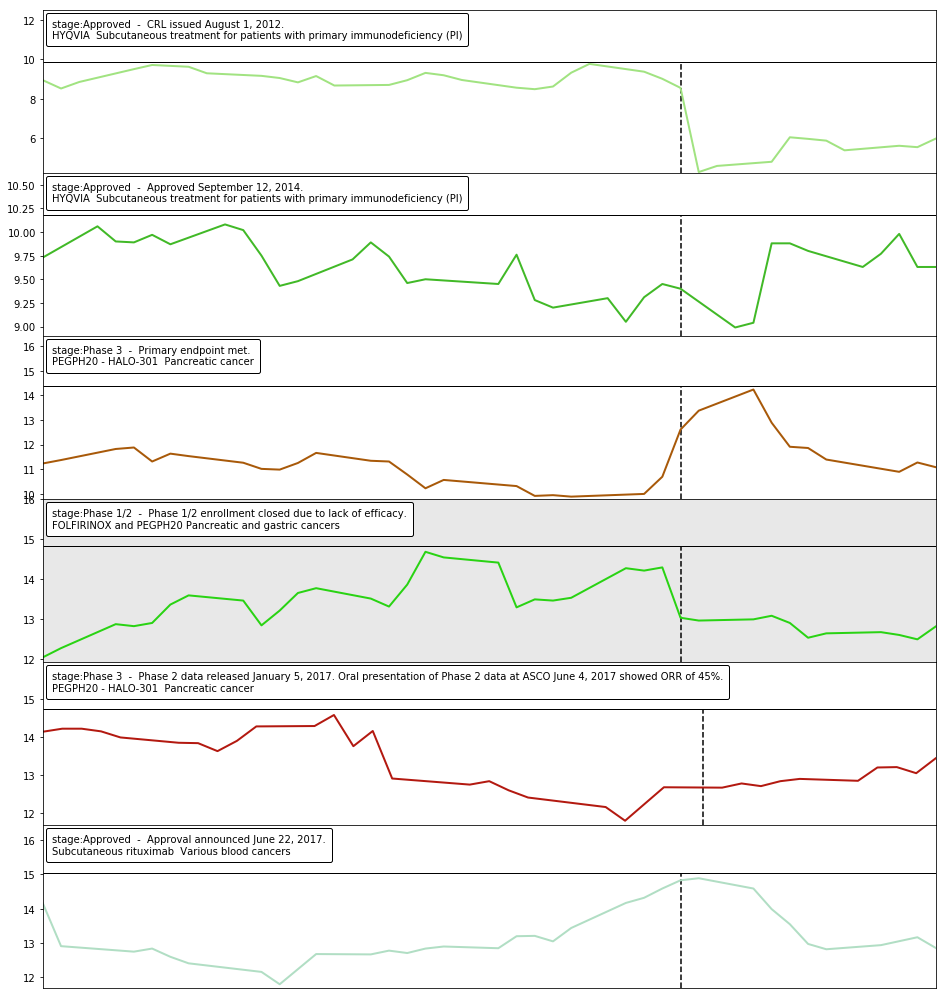

In [8]:
# You may need to install htmllib5,lxml, and BeautifulSoup4. In your terminal/command prompt run:

# conda install lxml
# conda install html5lib
# conda install BeautifulSoup4
# Then restart Jupyter Notebook. (or use pip install if you aren't using the Anaconda Distribution)
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import *
from pylab import text
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import quandl


# Quandl API key
quandl.ApiConfig.api_key = "UsYsv7dKGxHHQ5oURP4B"

# Some formatting
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_seq_items', 2)

# Only pull fresh PDUFA data
three_weeks_ago = relativedelta(weeks=3)
one_week_ahead = relativedelta(weeks=1)
one_hour_ago = datetime.now() - timedelta(hours=1)
if os.path.exists("history.csv"):
    filetime = datetime.fromtimestamp(os.path.getctime("history.csv"))
    if filetime < one_hour_ago:
        histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
        histdata[0].to_csv('history.csv',index=False)
else:
    histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
    histdata[0].to_csv('history.csv',index=False)

# Create dataframe
df = pd.read_csv('history.csv').set_index('Ticker')
df.index.name=None
df[["Date","Catalyst"]] = df.Catalyst.str.extract('(?P<Date>[0-9]{2}\/[0-9]{2}\/[0-9]{4})(?P<Catalyst>.*)', expand=True)
df['Date'] = pd.to_datetime(df['Date'])
df["Past"] = df["Date"] - DateOffset(weeks=5)
df["Future"] = df["Date"] + DateOffset(weeks=2)

df
# Set stock ticker
stockpick="HALO"
dataset=str(f"WIKI/{stockpick}")
# Set variables for plot creation
length = len(df.loc[stockpick].index)
count = 0
fig, axes = plt.subplots(nrows=length, ncols=1,figsize=(16,length * 3))
fig.subplots_adjust(hspace=0, wspace=0)
allplots=[]

# Combine all data together into list of dataframes, iterate through each part of the list, plot each frame.
while (count < length):
    pasttime= df.loc[stockpick].iloc[count]["Past"]
    futuretime= df.loc[stockpick].iloc[count]["Future"]
    pdufa=df.loc[stockpick].iloc[count]["Date"]
    annotate = df.loc[stockpick].iloc[count]["Date"] + timedelta(days=1)
    stage = df.loc[stockpick].iloc[count]["Stage"]
    catalyst = df.loc[stockpick].iloc[count]["Catalyst"]
    drug = df.loc[stockpick].iloc[count]["Drug"]
    
    #Annotation
    tooltip = f"stage:{stage}  -{catalyst}\n{drug}"
    at = AnchoredText(tooltip,
                      prop=dict(size=10), frameon=True,
                      loc=2, 
                      )
    at.patch.set_boxstyle("round,pad=0.2,rounding_size=0.2")
    axes[count].add_artist(at)
    axes[count].margins(0.0, 0.5)
    #Get quandl data
    mydata = quandl.get(dataset,start_date=pasttime,end_date=futuretime)
    allplots.append(mydata)
#     axes[count].annotate('local max', xy=(pdufa, allplots[count]["Close"].max()), xytext=(annotate, (allplots[count]["Close"].max() - allplots[count]["Close"].min()) * 0.9 + allplots[count]["Close"].min()),
#             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),)
    # Set y limit for notes
    axes[count].set_ylim(allplots[count]["Close"].min() * .99 , (allplots[count]["Close"].max()-allplots[count]["Close"].min()) * 0.5 + allplots[count]["Close"].max())
    axes[count].hlines(allplots[count]["Close"].max() * 1.01, allplots[count].head(1).index, allplots[count].tail(1).index, linestyle="-", lw=1, color='black')
    if count == 3:
        axes[count].set_facecolor((0.91, 0.91, 0.91))  

    axes[count].vlines(pdufa, allplots[count]["Close"].min() * .99, allplots[count]["Close"].max() * 1.01, linestyle="--", color='black')
    axes[count].plot(allplots[count].index,allplots[count]["Close"],c=np.random.rand(3,), lw=2, label=pdufa) 
    axes[count].axes.get_xaxis().set_visible(False) # remove x axis
    count = count + 1
plt.show()

In [3]:
# You may need to install htmllib5,lxml, and BeautifulSoup4. In your terminal/command prompt run:

# conda install lxml
# conda install html5lib
# conda install BeautifulSoup4
# Then restart Jupyter Notebook. (or use pip install if you aren't using the Anaconda Distribution)
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import *
from pylab import text
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import quandl


# Quandl API key
quandl.ApiConfig.api_key = "UsYsv7dKGxHHQ5oURP4B"

# Some formatting
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_seq_items', 2)

# Only pull fresh PDUFA data
three_weeks_ago = relativedelta(weeks=3)
one_week_ahead = relativedelta(weeks=1)
one_hour_ago = datetime.now() - timedelta(hours=1)
if os.path.exists("history.csv"):
    filetime = datetime.fromtimestamp(os.path.getctime("history.csv"))
    if filetime < one_hour_ago:
        histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
        histdata[0].to_csv('history.csv',index=False)
else:
    histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
    histdata[0].to_csv('history.csv',index=False)

# Create dataframe
df = pd.read_csv('history.csv').set_index('Ticker')
df.index.name=None
df[["Date","Catalyst"]] = df.Catalyst.str.extract('(?P<Date>[0-9]{2}\/[0-9]{2}\/[0-9]{4})(?P<Catalyst>.*)', expand=True)
df['Date'] = pd.to_datetime(df['Date'])
df["Past"] = df["Date"] - DateOffset(weeks=5)
df["Future"] = df["Date"] + DateOffset(weeks=2)

df
# Set stock ticker
stockpick="HALO"
dataset=str(f"WIKI/{stockpick}")
# Set variables for plot creation
length = len(df.loc[stockpick].index)
count = 0
allplots=[]
e = []
# Combine all data together into list of dataframes, iterate through each part of the list, plot each frame.
while (count < length):
    pasttime= df.loc[stockpick].iloc[count]["Past"]
    futuretime= df.loc[stockpick].iloc[count]["Future"]
    pdufa=df.loc[stockpick].iloc[count]["Date"]
    annotate = df.loc[stockpick].iloc[count]["Date"] + timedelta(days=1)
    stage = df.loc[stockpick].iloc[count]["Stage"]
    catalyst = df.loc[stockpick].iloc[count]["Catalyst"]
    drug = df.loc[stockpick].iloc[count]["Drug"]
    d = []
    #Annotation
    #Get quandl data
    mydata = quandl.get(dataset,start_date=pasttime,end_date=futuretime)
    allplots.append(mydata)
    i=0
#     print(len(allplots[count].index))
    total = len(allplots[count].index) - 1
    while (i < total):
        n = i + 1
        while (n < total):  # see 14 - 8 = 1.0 !!!
            rangevalue=(allplots[count].iloc[n]["Close"] - allplots[count].iloc[i]["Close"])
            d.append(rangevalue)
            range = f"{n} - {i}"
            n=n + 1
        i = i + 1
    e.append(d)
    count = count + 1
#need to add row names to see what the ranges are specifically.
finaldf=pd.DataFrame(e).transpose()
finaldf


,0,1,2,3,4,5,6,7
0,-0.420,0.33,0.14,-0.11,0.23,0.08,0.08,-1.250
1,-0.090,0.17,0.59,-0.39,0.83,0.08,0.08,-1.370
2,0.560,0.16,0.65,-0.07,0.78,0.01,0.01,-1.410
3,0.770,0.24,0.08,0.37,0.86,-0.15,-0.15,-1.320
4,0.680,0.14,0.40,0.36,1.32,-0.29,-0.29,-1.560
5,0.350,0.35,0.30,0.64,1.55,-0.30,-0.30,-1.750
6,0.220,0.29,0.03,0.67,1.42,-0.51,-0.51,-2.000
7,0.110,0.02,-0.22,0.61,0.80,-0.24,-0.24,-2.360
8,-0.110,-0.30,-0.25,0.48,1.17,0.14,0.14,-1.920
9,0.210,-0.25,0.02,1.15,1.61,0.15,0.15,-1.480


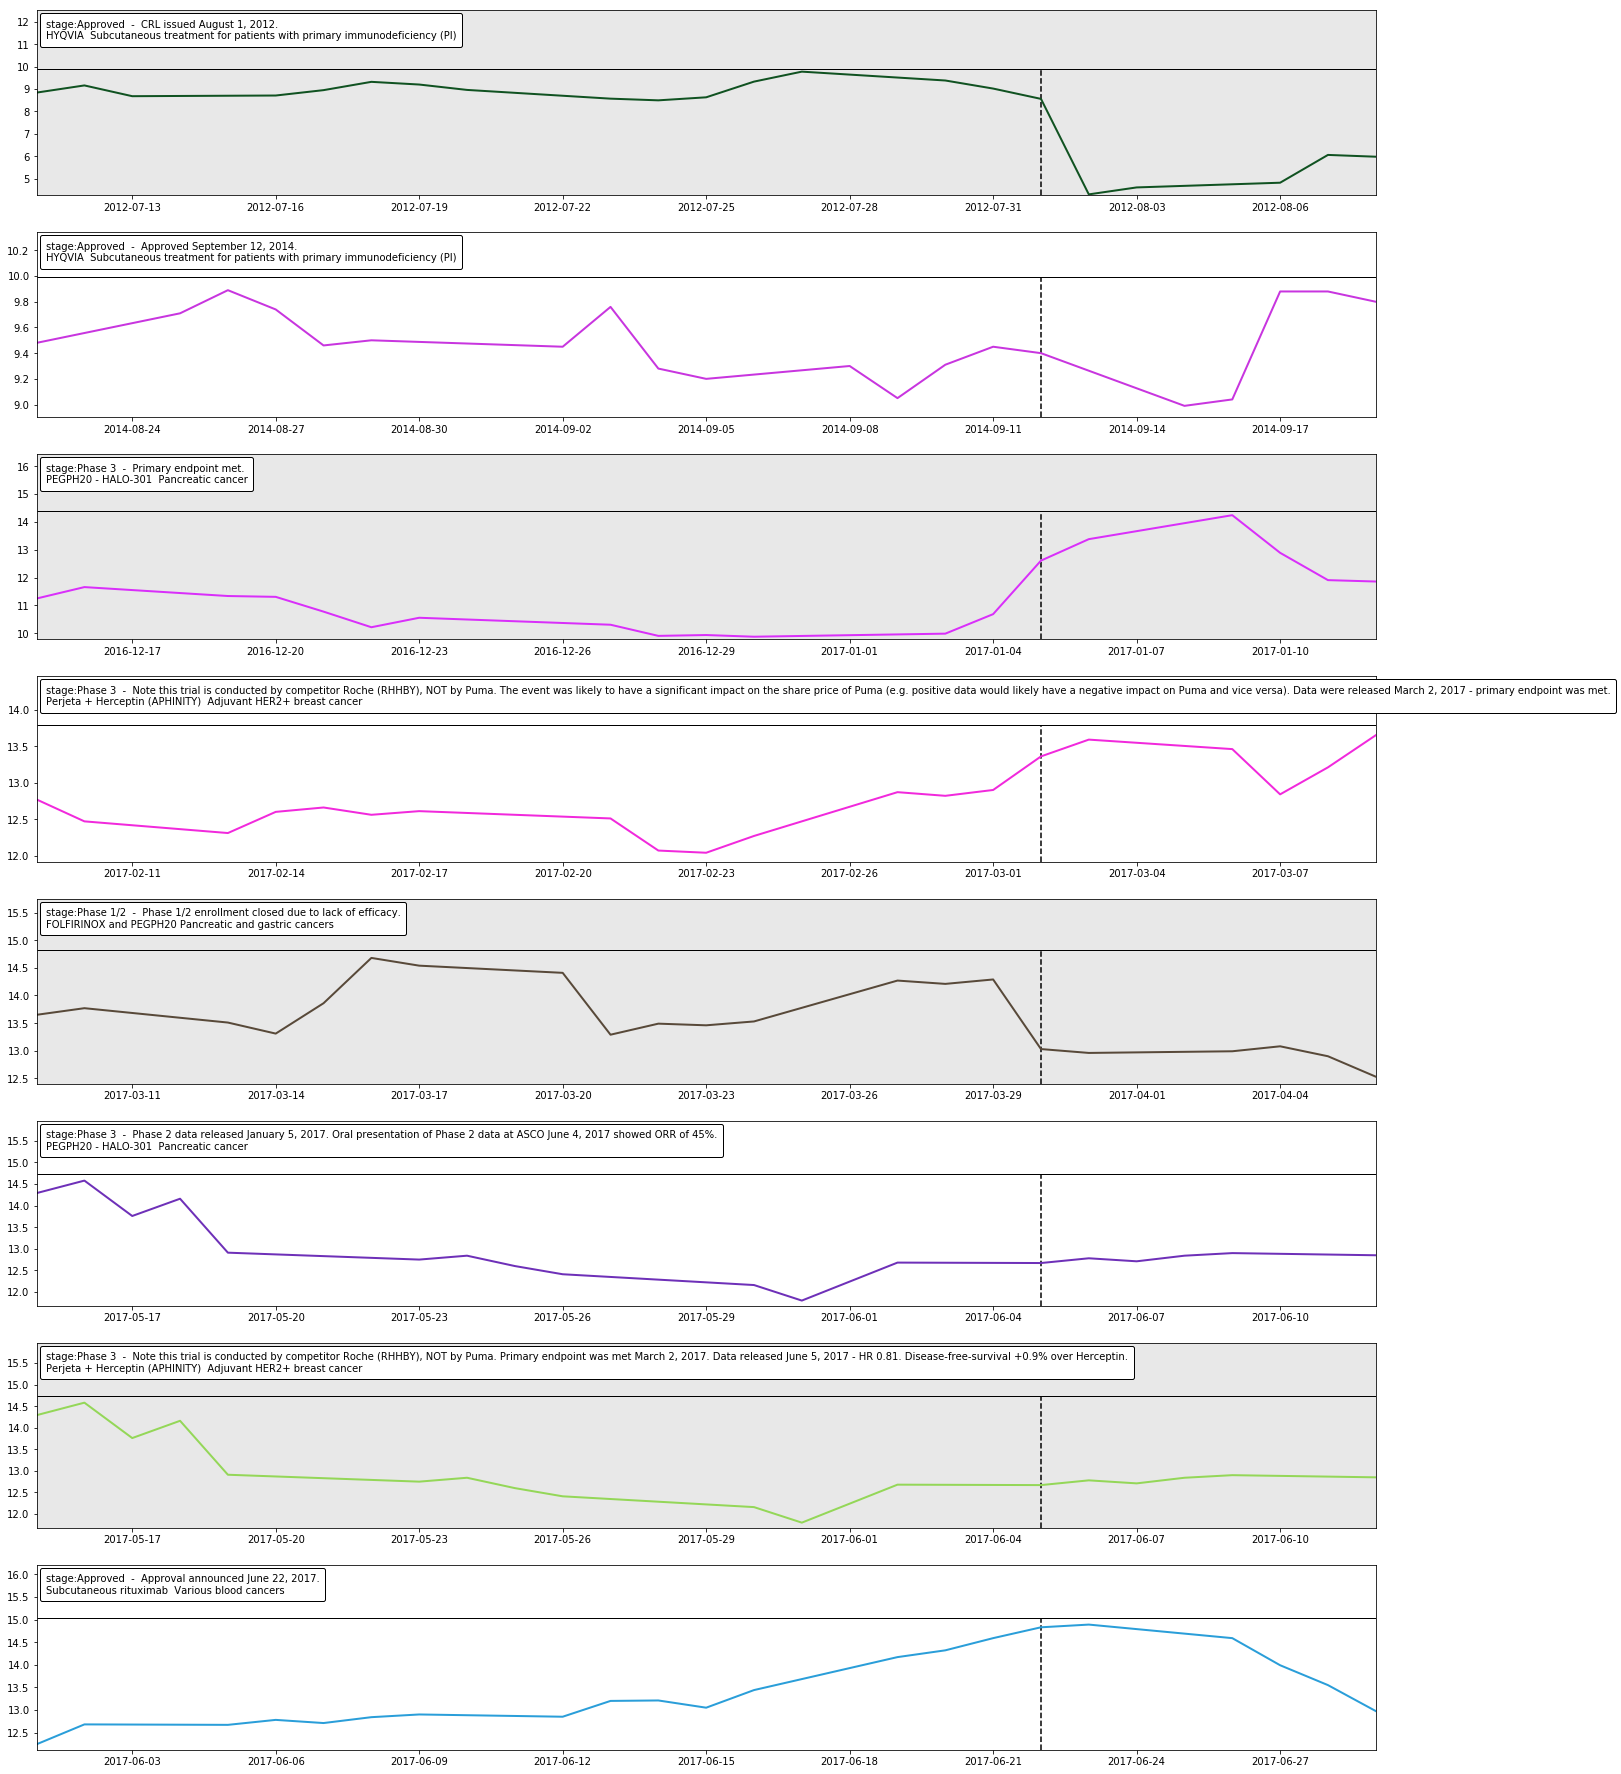

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2012-07-11,9.06,9.0600,8.7600,8.840,697000.0,0.0,1.0,9.06,9.0600,8.7600,8.840,697000.0
2012-07-12,8.80,9.1600,8.5600,9.160,867200.0,0.0,1.0,8.80,9.1600,8.5600,9.160,867200.0
2012-07-13,8.86,9.0200,8.6300,8.680,858800.0,0.0,1.0,8.86,9.0200,8.6300,8.680,858800.0
2012-07-16,8.69,8.8100,8.4200,8.710,459200.0,0.0,1.0,8.69,8.8100,8.4200,8.710,459200.0
2012-07-17,8.79,9.0100,8.6800,8.950,859100.0,0.0,1.0,8.79,9.0100,8.6800,8.950,859100.0
2012-07-18,8.92,9.3450,8.9200,9.320,634700.0,0.0,1.0,8.92,9.3450,8.9200,9.320,634700.0
2012-07-19,9.40,9.5400,9.1800,9.200,441500.0,0.0,1.0,9.40,9.5400,9.1800,9.200,441500.0
2012-07-20,9.15,9.1801,8.8901,8.960,627600.0,0.0,1.0,9.15,9.1801,8.8901,8.960,627600.0
2012-07-23,8.72,8.7300,8.4000,8.570,692000.0,0.0,1.0,8.72,8.7300,8.4000,8.570,692000.0


In [15]:
# You may need to install htmllib5,lxml, and BeautifulSoup4. In your terminal/command prompt run:

# conda install lxml
# conda install html5lib
# conda install BeautifulSoup4
# Then restart Jupyter Notebook. (or use pip install if you aren't using the Anaconda Distribution)
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import *
from pandas.tseries.holiday import USFederalHolidayCalendar
from pylab import text
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import quandl


# Quandl API key
quandl.ApiConfig.api_key = "UsYsv7dKGxHHQ5oURP4B"

# Some formatting
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_seq_items', 2)

# Only pull fresh PDUFA data
three_weeks_ago = relativedelta(weeks=3)
one_week_ahead = relativedelta(weeks=1)
one_hour_ago = datetime.now() - timedelta(hours=1)
if os.path.exists("history.csv"):
    filetime = datetime.fromtimestamp(os.path.getctime("history.csv"))
    if filetime < one_hour_ago:
        histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
        histdata[0].to_csv('history.csv',index=False)
else:
    histdata = pd.read_html("https://www.biopharmcatalyst.com/calendars/historical-catalyst-calendar")
    histdata[0].to_csv('history.csv',index=False)

# Create dataframe
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
df = pd.read_csv('history.csv').set_index('Ticker')
df.index.name=None
df[["Date","Catalyst"]] = df.Catalyst.str.extract('(?P<Date>[0-9]{2}\/[0-9]{2}\/[0-9]{4})(?P<Catalyst>.*)', expand=True)
df['Date'] = pd.to_datetime(df['Date'])
df['day_of_week'] = df['Date'].dt.day_name()
df["Original_PDUFA"] = df["Date"]
df["Date"] = df["Date"].map(lambda x : x + 0*us_bd)

df["Past"] = df["Date"] - DateOffset(weeks=3)
df["Future"] = df["Date"] + DateOffset(weeks=1)
# Set stock ticker
stockpick="HALO"
dataset=str(f"WIKI/{stockpick}")
# Set variables for plot creation
length = len(df.loc[stockpick].index)
count = 0
fig, axes = plt.subplots(nrows=length, ncols=1,figsize=(24,length * 4))
fig.subplots_adjust(hspace=.2, wspace=0)
allplots=[]

# Combine all data together into list of dataframes, iterate through each part of the list, plot each frame.
while (count < length):
    pasttime= df.loc[stockpick].iloc[count]["Past"]
    futuretime= df.loc[stockpick].iloc[count]["Future"]
    pdufa=df.loc[stockpick].iloc[count]["Date"]
    annotate = df.loc[stockpick].iloc[count]["Date"] + timedelta(days=1)
    stage = df.loc[stockpick].iloc[count]["Stage"]
    catalyst = df.loc[stockpick].iloc[count]["Catalyst"]
    drug = df.loc[stockpick].iloc[count]["Drug"]
    
    #Annotation
    tooltip = f"stage:{stage}  -{catalyst}\n{drug}"
    at = AnchoredText(tooltip,
                      prop=dict(size=10), frameon=True,
                      loc=2, 
                      )
    at.patch.set_boxstyle("round,pad=0.2,rounding_size=0.2")
    axes[count].add_artist(at)
    axes[count].margins(0.0, 0.5)
    #Get quandl data
    mydata = quandl.get(dataset,start_date=pasttime,end_date=futuretime)
    allplots.append(mydata)
#     axes[count].annotate('local max', xy=(pdufa, allplots[count]["Close"].max()), xytext=(annotate, (allplots[count]["Close"].max() - allplots[count]["Close"].min()) * 0.9 + allplots[count]["Close"].min()),
#             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),)
    # Set y limit for notes
    axes[count].set_ylim(allplots[count]["Close"].min() * .99 , (allplots[count]["Close"].max()-allplots[count]["Close"].min()) * 0.5 + allplots[count]["Close"].max())
    axes[count].hlines(allplots[count]["Close"].max() * 1.01, allplots[count].head(1).index, allplots[count].tail(1).index, linestyle="-", lw=1, color='black')
    if count % 2 == 0:
        axes[count].set_facecolor((0.91, 0.91, 0.91))  

    axes[count].vlines(pdufa, allplots[count]["Close"].min() * .99, allplots[count]["Close"].max() * 1.01, linestyle="--", color='black')
    axes[count].plot(allplots[count].index,allplots[count]["Close"],c=np.random.rand(3,), lw=2, label=pdufa) 
#     axes[count].axes.get_xaxis().set_visible(False) # remove x axis
    count = count + 1
plt.show() # need to show x axis temporarily to ensure null times aren't being added
allplots[0]

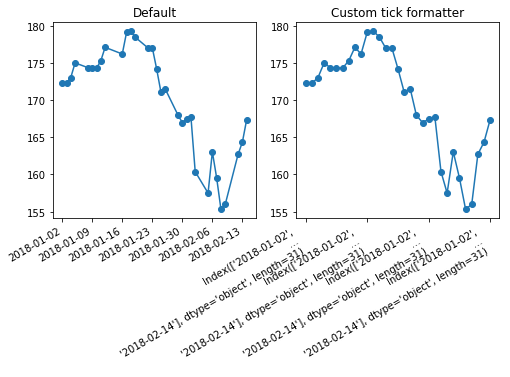

In [30]:

"""
=====================================
Custom tick formatter for time series
=====================================

When plotting time series, e.g., financial time series, one often wants
to leave out days on which there is no data, i.e. weekends.  The example
below shows how to use an 'index formatter' to achieve the desired plot
"""
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cbook as cbook
import matplotlib.ticker as ticker
r = quandl.get("wiki/aapl",start_date="2018-01-01",end_date="2018-02-14")


# first we'll do it the default way, with gaps on weekends
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
ax = axes[0]
ax.plot(r.index, r['Adj. Close'], 'o-')
ax.set_title("Default")
fig.autofmt_xdate()

# next we'll write a custom formatter
N = len(r)
ind = np.arange(N)  # the evenly spaced plot indices


def format_date(x, pos=None):
    thisind = np.clip(int(x + 0.5), 0, N - 1)
    return r.index.strftime('%Y-%m-%d')

ax = axes[1]
ax.plot(ind, r['Adj. Close'], 'o-')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
ax.set_title("Custom tick formatter")
fig.autofmt_xdate()

plt.show()